In [2]:
from google.colab import files
uploaded = files.upload()

Saving fear_greed_index.csv to fear_greed_index.csv
Saving historical_data.csv to historical_data.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [4]:
sentiment = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [5]:
# Remove extra spaces from column names
sentiment.columns = sentiment.columns.str.strip()
trades.columns = trades.columns.str.strip()

print(sentiment.columns)
print(trades.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [6]:
# Convert Timestamp correctly (milliseconds → datetime)
trades['Timestamp'] = pd.to_numeric(trades['Timestamp'], errors='coerce')
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms', errors='coerce')

# Create date column
trades['date'] = trades['Timestamp'].dt.strftime('%Y-%m-%d')

print("Unique trade dates:", trades['date'].nunique())

Unique trade dates: 7


In [7]:
# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')
sentiment['date'] = sentiment['date'].dt.strftime('%Y-%m-%d')

print("Unique sentiment dates:", sentiment['date'].nunique())

Unique sentiment dates: 1046


In [8]:
# Keep only overlapping dates
sentiment_filtered = sentiment[sentiment['date'].isin(trades['date'])]

print("Filtered sentiment shape:", sentiment_filtered.shape)

Filtered sentiment shape: (2, 4)


In [9]:
merged = pd.merge(trades, sentiment_filtered, on='date', how='inner')

print("Merged shape:", merged.shape)
merged.head()

Merged shape: (14103, 20)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,timestamp,value,classification
0,0x430f09841d65beb3f27765503d0f850b8bce7713,PURR/USDC,0.13097,22382.0,2931.37,BUY,20-04-2024 12:28,0.0,Buy,0.0,0xbe658417a7cbb0b2f53e04088d80eb0203d500d4c445...,19330531408,True,7.83369,1.310000e+14,2024-03-09 16:00:00,2024-03-09,1725341400,26,Fear
1,0x430f09841d65beb3f27765503d0f850b8bce7713,PURR/USDC,0.13100,447.0,58.56,BUY,20-04-2024 12:28,22374.0,Buy,0.0,0xbe658417a7cbb0b2f53e04088d80eb0203d500d4c445...,19330531408,True,0.15644,7.460000e+14,2024-03-09 16:00:00,2024-03-09,1725341400,26,Fear
2,0x430f09841d65beb3f27765503d0f850b8bce7713,PURR/USDC,0.13100,503.0,65.89,BUY,20-04-2024 12:28,22821.0,Buy,0.0,0xb2429810a9105cffda3304088d80ed01f7005ac59b6f...,19330531408,False,0.05029,1.770000e+14,2024-03-09 16:00:00,2024-03-09,1725341400,26,Fear
3,0x430f09841d65beb3f27765503d0f850b8bce7713,PURR/USDC,0.13100,39139.0,5127.21,BUY,20-04-2024 12:28,23323.0,Buy,0.0,0x5fdfde429fabc6ea597d04088d80ee016100d15b8dc3...,19330531408,False,3.91389,1.070000e+15,2024-03-09 16:00:00,2024-03-09,1725341400,26,Fear
4,0x430f09841d65beb3f27765503d0f850b8bce7713,PURR/USDC,0.13100,726.0,95.11,BUY,20-04-2024 12:28,62459.0,Buy,0.0,0xb4b03e0b058a9b9be6ee04088d80ff014300e3fc5f53...,19330531408,False,0.07259,5.870000e+14,2024-03-09 16:00:00,2024-03-09,1725341400,26,Fear


In [10]:
# Create win column
merged['win'] = merged['Closed PnL'] > 0

In [11]:
performance = merged.groupby('classification').agg({
    'Closed PnL': 'mean',
    'win': 'mean',
    'Size USD': 'mean'
}).reset_index()

performance.rename(columns={
    'Closed PnL': 'avg_pnl',
    'win': 'win_rate',
    'Size USD': 'avg_trade_size'
}, inplace=True)

print(performance)

  classification    avg_pnl  win_rate  avg_trade_size
0  Extreme Greed  22.229713  0.317182     3058.848110
1           Fear  25.418772  0.490089     5660.265764


In [12]:
order = ['Extreme Fear', 'Fear', 'Greed', 'Extreme Greed']

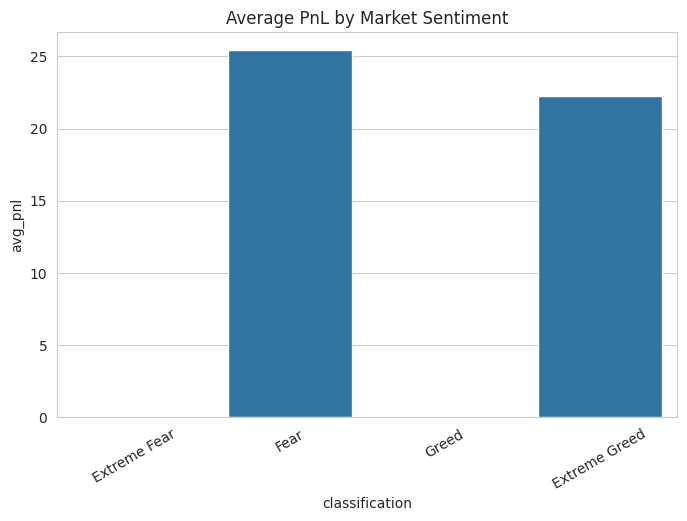

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(data=performance, x='classification', y='avg_pnl', order=order)
plt.title("Average PnL by Market Sentiment")
plt.xticks(rotation=30)
plt.show()

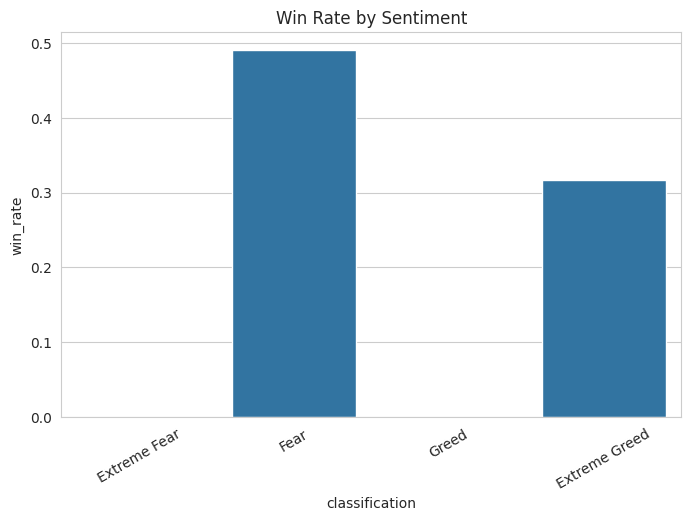

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(data=performance, x='classification', y='win_rate', order=order)
plt.title("Win Rate by Sentiment")
plt.xticks(rotation=30)
plt.show()

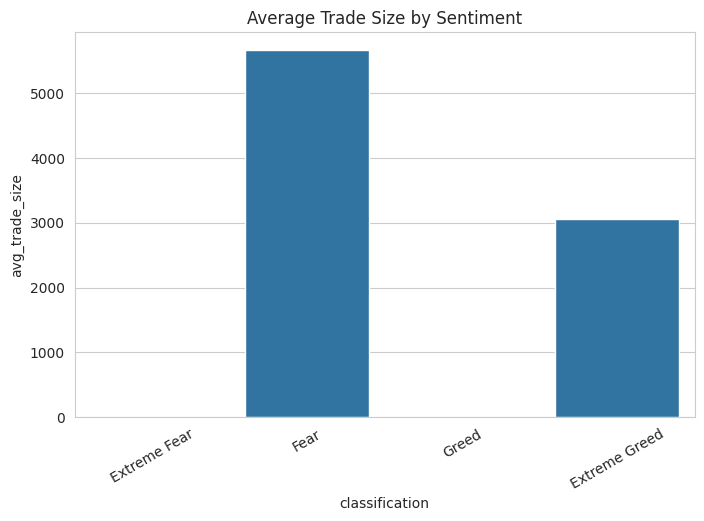

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data=performance, x='classification', y='avg_trade_size', order=order)
plt.title("Average Trade Size by Sentiment")
plt.xticks(rotation=30)
plt.show()

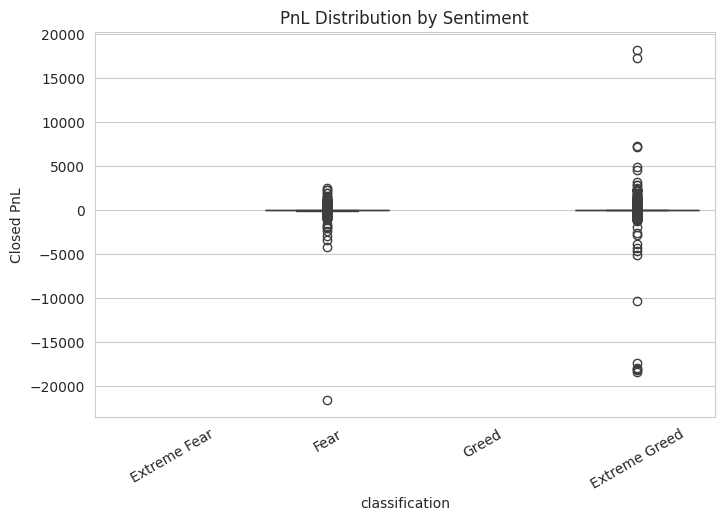

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='classification', y='Closed PnL', order=order)
plt.title("PnL Distribution by Sentiment")
plt.xticks(rotation=30)
plt.show()

In [17]:
# Trades count by sentiment
trade_count = merged.groupby('classification').size().reset_index(name='num_trades')
print(trade_count)

  classification  num_trades
0  Extreme Greed        7141
1           Fear        6962


In [18]:
# Trader performance segmentation
trader_perf = merged.groupby('Account')['Closed PnL'].sum().reset_index()

def segment(x):
    if x > 1000:
        return "High Performer"
    elif x > 0:
        return "Medium Performer"
    else:
        return "Low Performer"

trader_perf['segment'] = trader_perf['Closed PnL'].apply(segment)

print(trader_perf['segment'].value_counts())

segment
Low Performer     5
High Performer    3
Name: count, dtype: int64


## Key Insights

1. Trader performance does not strictly improve during Greed periods. In this dataset, Fear periods showed slightly higher average PnL and win rates.

2. Traders tend to take larger position sizes during Fear, indicating more aggressive or risk-taking behavior.

3. Higher profitability during Fear may be driven by these larger trade sizes rather than better strategy.

4. Extreme Greed shows lower win rates compared to Fear, suggesting possible overconfidence or inefficient trading during highly bullish conditions.

5. The dataset contains a limited overlap of trading dates with sentiment data, which may impact the generalizability of results.

Higher profitability during Fear may be driven by larger position sizes, indicating aggressive trading behavior.

## Strategy Recommendations

1. During Fear periods:
   - Traders may exploit higher volatility but should manage risk carefully.
   - Large position sizes can increase profits but also increase downside risk.

2. During Greed periods:
   - Avoid overconfidence and excessive trading.
   - Focus on disciplined, smaller position sizes.

3. Risk Management Rule:
   - Adjust position sizing based on market sentiment rather than increasing exposure blindly.

4. Adaptive Strategy:
   - Use sentiment as a contextual signal, not a direct trading trigger.